In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Layer, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tqdm import tqdm

from tf__resnet.resnet_builder.resnet import ResnetBuilder

In [2]:
class MixUp(Layer):
    def __init__(self,**kwargs):
        super(MixUp, self).__init__(**kwargs)

    def call(self,x):
        '''x = [data1, data2, mixup_ratio]
        '''
        x1 = x[0]
        x2 = x[1]
        lam = x[2] # mixing ratio
        
        # mixup ratio tensor reshape for add
        x_shape = len(x1.shape)
        lam_shape = len(lam.shape)
        for i in range(x_shape-lam_shape):
            lam = tf.expand_dims(lam,-1)

        return tf.add(tf.math.multiply(x1,lam) , tf.math.multiply(x2,1.-lam))

In [3]:
class Normal_Resnet(tf.keras.Model):
    def __init__(self, resnet_name="ResNet18"):
        super(Normal_Resnet,self).__init__()
        self.resnet = ResnetBuilder(name="ResNet18",include_top=False)
        self.fin_layer = Dense(class_num,activation="softmax")
        
        
    def call(self, x):
        # input x = [data1, data2, mixup_ratio]
        # Not using data2, ram
        x1 = x[0]
        
        h = self.resnet(x1)
        output = self.fin_layer(h)
        return output

In [4]:
class Standard_Mixup_Resnet(tf.keras.Model):
    def __init__(self, resnet_name="ResNet18"):
        super(Standard_Mixup_Resnet,self).__init__()
        self.resnet = ResnetBuilder(name="ResNet18",include_top=False)
        self.mixup = MixUp()
        self.fin_layer = Dense(class_num,activation="softmax")
        
        
    def call(self, x):
        # input x = [data1, data2, mixup_ratio]
        h = self.mixup(x)
        h = self.resnet(h)
        output = self.fin_layer(h)
        return output

In [5]:
class FinLayer_Mixup_Resnet(tf.keras.Model):
    def __init__(self, resnet_name="ResNet18"):
        super(FinLayer_Mixup_Resnet,self).__init__()
        self.resnet = ResnetBuilder(name="ResNet18",include_top=False)
        self.mixup = MixUp()
        self.fin_layer = Dense(class_num,activation="softmax")
        
        
    def call(self, x):
        # input x = [data1, data2, mixup_ratio]
        x1 = x[0]
        x2 = x[1]
        lam = x[2] # mixing ratio
        
        h1 = self.resnet(x1)
        h2 = self.resnet(x2)
        h = self.mixup([h1,h2,lam])
        output = self.fin_layer(h)
        return output

# dataset

#### load and standardzing dataset

#### create a train dataset for eval whose data size is sam

In [6]:
# CIFAR 10 Information
class_num = 10
ch_num = 3
img_size = 32

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, class_num)
Y_test = to_categorical(y_test, class_num)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [7]:
def data_balance(labels,data_num):
    """data choice function for label balanced data
    """
    labels_dic = {}
    ids = np.arange(labels.shape[0])
    for label in range(len(np.unique(labels))):
        label_choice = ids[labels==label]
        shfl = np.random.choice(label_choice.shape[0], data_num, replace=False)
        labels_dic[label] = label_choice[shfl]
    data_choice = np.concatenate([labels_dic[label] for label in labels_dic.keys()],axis=0)
    shfl = np.random.choice(data_choice.shape[0],data_choice.shape[0],replace=False)
    data_choice = data_choice[shfl]

    # check
    shfl_labels = labels[data_choice]
    assert len(np.unique(shfl_labels)) == len(np.unique(labels))
    assert (np.unique(shfl_labels,return_counts=True)[1] == data_num).all()

    return data_choice

In [8]:
choice = data_balance(y_train.reshape(-1),data_num=Y_test.shape[0]//10)
X_train_eval = X_train[choice]
Y_train_eval = Y_train[choice]
np.sum(Y_train_eval,axis=0)

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32)

In [9]:
# random flip image
def flip_image(image):
    return tf.image.random_flip_left_right(image)

# random crop shift range
shift_range = 0.1
expand_target_size = int(img_size*(shift_range+1))
def image_shift(image):
    # padding
    image = tf.image.resize_with_crop_or_pad(
                    image,
                    expand_target_size,
                    expand_target_size
                    )
    #random crop
    image = tf.image.random_crop(
                    image,
                    size=[img_size, img_size, ch_num]
                    )
    return image

# Training

In [10]:
class training_model():
    def __init__(self,X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=0.2, batch_size=64):
        self.mixup = True
        self.model = self.define_model()
        self.model([Input((32,32,3)),Input((32,32,3)),Input((1,))])
        self.model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        self.model.summary()
        self.model_vals = self.model.trainable_variables
        self.batch_size = batch_size
        self.alpha = alpha
        self.datas = [X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test]


    def define_model(self):
        raise Exception("please define your model")
 


    def create_mixup_dataset(self,X_data,Y_data,mixup=True):
        # create train data for mixup
        if mixup==True:
            shfl1 = np.random.choice(X_data.shape[0],X_data.shape[0],replace=False)
            shfl2 = np.random.choice(X_data.shape[0],X_data.shape[0],replace=False)
        else:
            shfl1 = np.arange(X_data.shape[0])
            shfl2 = np.arange(X_data.shape[0])
            
        X_data1 = X_data[shfl1]
        X_data2 = X_data[shfl2]
        Y_data1 = Y_data[shfl1]
        Y_data2 = Y_data[shfl2]

        # ratio datset
        ratio_array = np.random.beta(self.alpha, self.alpha, X_data.shape[0]).reshape(-1,1).astype(np.float32)
        ratio = tf.data.Dataset.from_tensor_slices(ratio_array)

        # input_dataset for mixup
        input_ds1 = tf.data.Dataset.from_tensor_slices(X_data1)
        input_ds1 = input_ds1.map(flip_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).map(image_shift,num_parallel_calls=tf.data.experimental.AUTOTUNE)
        input_ds2 = tf.data.Dataset.from_tensor_slices(X_data2)
        input_ds2 = input_ds2.map(flip_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).map(image_shift,num_parallel_calls=tf.data.experimental.AUTOTUNE)
        input_ds = tf.data.Dataset.zip((input_ds1, input_ds2, ratio))

        # target_dataset
        if mixup==True:
            Y_data = Y_data1*ratio_array + Y_data2*(1.-ratio_array)
        else:
            Y_data=Y_data1
        target_ds = tf.data.Dataset.from_tensor_slices(Y_data)
        
        # dataset
        ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size)
        batch_num = int(np.ceil(X_data.shape[0]/self.batch_size))
        
        return ds, batch_num
    
    def print_target_sample(self,iterator):
        x,y = next(iterator)
        print(y[:5])
        print("")
        
    
    @tf.function
    def train_step(self,b_input, b_target):
        with tf.GradientTape() as tape:
            preds = self.model(b_input)
            loss = categorical_crossentropy(b_target, preds)
        grads = tape.gradient(loss, self.model_vals)
        self.optimizer.apply_gradients(zip(grads, self.model_vals))

        
    def minibatch_training(self):
            b_input, b_target = next(self.train_iter)
            self.train_step(b_input,b_target)
                
                       
    def train(self,
                    epochs=200, 
                    max_patience=5, # early stop patience
                    ):
        # create valid, train(for eval) dataset
        X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test = self.datas
        test_ds, test_batch_num = self.create_mixup_dataset(X_test, Y_test,mixup=False)
        train_e_ds, train_e_batch_num = self.create_mixup_dataset(X_train_eval, Y_train_eval,mixup=False)
        train_ds, train_batch_num = self.create_mixup_dataset(X_train, Y_train,mixup=self.mixup)
        
        self.optimizer =  tf.keras.optimizers.Adam() # optimizer setting
        losses = [] # valid loss history
        patience=0 # early stop patience
        
        #First Evaluation
        print("First_evaluation")
        [train_loss, train_acc] = self.model.evaluate(train_e_ds,steps=train_e_batch_num, verbose=1)
        [valid_loss, valid_acc] = self.model.evaluate(test_ds,steps=test_batch_num, verbose=1)
        best_train_losses = [train_loss, train_acc]
        best_valid_losses = [valid_loss, valid_acc]
        min_loss = valid_loss
        #losses.append(valid_loss)
        print("epoch:",0,"-----",end="")
        print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
        print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4))
        
        for phase, iterator in zip(["train","train-eval","test"],[iter(train_ds),iter(train_e_ds),iter(test_ds)]):
            print(phase,"sample")
            self.print_target_sample(iterator)
            
        
        
        # start training
        for epoch in range(epochs):
            # create mixuped dataset for train
            train_ds, train_batch_num = self.create_mixup_dataset(X_train, Y_train,mixup=self.mixup)
            self.train_iter = iter(train_ds)
            if epoch == 0: print("batch num ",train_batch_num)
                
            for batch in tqdm(range(train_batch_num)):
                # minibatch training
                self.minibatch_training()
                
            # evaluation at epoch end
            [train_loss, train_acc] = self.model.evaluate(train_e_ds,steps=train_e_batch_num, verbose=0)
            [valid_loss, valid_acc] = self.model.evaluate(test_ds,steps=test_batch_num, verbose=0)
            losses.append(valid_loss)
            print("epoch:",epoch+1,"-----",end="")
            print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
            print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4),end="")
            
            if min_loss > valid_loss:
                self.model.save_weights(os.path.join("./model.h5", ))
                best_train_losses = [train_loss, train_acc]
                best_valid_losses = [valid_loss, valid_acc]
                min_loss = valid_loss
                patience=0
                print("     loss improved!")
            else:
                patience+=1
                print("")
                
            # early stopping
            if patience>max_patience:break

        print("-------------------------------")
        print("Training Results at best validation loss")
        print("train loss :",round(best_train_losses[0], 4), ",train acc: ",round(best_train_losses[1], 4),end="")
        print(",  valid loss :",round(best_valid_losses[0], 4), ",vaild acc: ",round(best_valid_losses[1], 4))
        
        return losses, [best_train_losses,best_valid_losses]

# Experiment

In [11]:
result_dict = {}

## MIXUP at Final Layer

In [12]:
class FinalLayer_MIXUP_CIFAR10(training_model):
    def define_model(self):
        self.mixup = True
        return FinLayer_Mixup_Resnet()

In [13]:
model = FinalLayer_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=0.04)
result_dict["fin_0.04"] = model.train()

Model: "fin_layer__mixup__resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up (MixUp)               (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 3s 17ms/step - loss: 9.3591 - accuracy: 0.1361
epoch: 0 -----train loss : 9.3432 ,train acc:  0.1403,  valid loss : 9.3591 ,vaild acc:  0.1361
train sample
tf.Tensor(
[[0.0000000e+00 9.9999911e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:39<00:00, 19.70it/s]


epoch: 1 -----train loss : 1.3425 ,train acc:  0.5173,  valid loss : 1.3405 ,vaild acc:  0.5196     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.54it/s]


epoch: 2 -----train loss : 1.1226 ,train acc:  0.6018,  valid loss : 1.1332 ,vaild acc:  0.5923     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.57it/s]


epoch: 3 -----train loss : 1.0435 ,train acc:  0.6245,  valid loss : 1.0631 ,vaild acc:  0.6192     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.03it/s]


epoch: 4 -----train loss : 0.9406 ,train acc:  0.6706,  valid loss : 0.985 ,vaild acc:  0.6551     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.12it/s]


epoch: 5 -----train loss : 0.9567 ,train acc:  0.6688,  valid loss : 1.0125 ,vaild acc:  0.6613


100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


epoch: 6 -----train loss : 0.8625 ,train acc:  0.7007,  valid loss : 0.9364 ,vaild acc:  0.6799     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.02it/s]


epoch: 7 -----train loss : 0.7949 ,train acc:  0.7246,  valid loss : 0.8721 ,vaild acc:  0.7007     loss improved!


100%|██████████| 782/782 [00:28<00:00, 11.21it/s]


epoch: 8 -----train loss : 0.7344 ,train acc:  0.749,  valid loss : 0.8358 ,vaild acc:  0.7102     loss improved!


100%|██████████| 782/782 [00:28<00:00, 31.87it/s]


epoch: 9 -----train loss : 0.6957 ,train acc:  0.7552,  valid loss : 0.817 ,vaild acc:  0.7165     loss improved!


100%|██████████| 782/782 [00:27<00:00, 27.95it/s]


epoch: 10 -----train loss : 0.7 ,train acc:  0.7582,  valid loss : 0.8389 ,vaild acc:  0.7167


100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


epoch: 11 -----train loss : 0.6691 ,train acc:  0.7738,  valid loss : 0.8194 ,vaild acc:  0.7255


100%|██████████| 782/782 [00:28<00:00, 22.35it/s]


epoch: 12 -----train loss : 0.6101 ,train acc:  0.7895,  valid loss : 0.7654 ,vaild acc:  0.7377     loss improved!


100%|██████████| 782/782 [00:29<00:00, 31.34it/s]


epoch: 13 -----train loss : 0.5996 ,train acc:  0.7958,  valid loss : 0.7711 ,vaild acc:  0.745


100%|██████████| 782/782 [00:28<00:00, 27.16it/s]


epoch: 14 -----train loss : 0.5751 ,train acc:  0.8077,  valid loss : 0.7481 ,vaild acc:  0.7451     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.59it/s]


epoch: 15 -----train loss : 0.6016 ,train acc:  0.7961,  valid loss : 0.7904 ,vaild acc:  0.7347


100%|██████████| 782/782 [00:27<00:00, 28.62it/s]


epoch: 16 -----train loss : 0.5397 ,train acc:  0.8138,  valid loss : 0.7503 ,vaild acc:  0.747


100%|██████████| 782/782 [00:28<00:00, 27.80it/s]


epoch: 17 -----train loss : 0.4822 ,train acc:  0.8378,  valid loss : 0.706 ,vaild acc:  0.7644     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]


epoch: 18 -----train loss : 0.471 ,train acc:  0.8372,  valid loss : 0.7256 ,vaild acc:  0.7557


100%|██████████| 782/782 [00:37<00:00, 31.09it/s]


epoch: 19 -----train loss : 0.4305 ,train acc:  0.8538,  valid loss : 0.713 ,vaild acc:  0.7654


100%|██████████| 782/782 [00:29<00:00, 26.90it/s]


epoch: 20 -----train loss : 0.4619 ,train acc:  0.8438,  valid loss : 0.7433 ,vaild acc:  0.7583


100%|██████████| 782/782 [00:40<00:00, 19.19it/s]


epoch: 21 -----train loss : 0.473 ,train acc:  0.8386,  valid loss : 0.7547 ,vaild acc:  0.7555


100%|██████████| 782/782 [00:31<00:00, 24.56it/s]


epoch: 22 -----train loss : 0.3975 ,train acc:  0.8668,  valid loss : 0.7087 ,vaild acc:  0.7717


100%|██████████| 782/782 [00:27<00:00, 28.15it/s]


epoch: 23 -----train loss : 0.4003 ,train acc:  0.8684,  valid loss : 0.7345 ,vaild acc:  0.7658
-------------------------------
Training Results at best validation loss
train loss : 0.4822 ,train acc:  0.8378,  valid loss : 0.706 ,vaild acc:  0.7644


In [14]:
model = FinalLayer_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=0.2)
result_dict["fin_0.2"] = model.train()

Model: "fin_layer__mixup__resnet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_1 (MixUp)             (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 3s 18ms/step - loss: 13.3396 - accuracy: 0.1011
epoch: 0 -----train loss : 13.3728 ,train acc:  0.1015,  valid loss : 13.3396 ,vaild acc:  0.1011
train sample
tf.Tensor(
[[0.7094555  0.         0.         0.         0.         0.
  0.         0.         0.2905445  0.        ]
 [0.9953368  0.    

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:39<00:00,  3.24it/s]


epoch: 1 -----train loss : 1.3818 ,train acc:  0.5128,  valid loss : 1.3817 ,vaild acc:  0.511     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.04it/s]


epoch: 2 -----train loss : 1.1376 ,train acc:  0.5958,  valid loss : 1.1633 ,vaild acc:  0.5915     loss improved!


100%|██████████| 782/782 [00:28<00:00, 29.24it/s]


epoch: 3 -----train loss : 1.0921 ,train acc:  0.6234,  valid loss : 1.1276 ,vaild acc:  0.6104     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.54it/s]


epoch: 4 -----train loss : 1.0364 ,train acc:  0.6441,  valid loss : 1.0907 ,vaild acc:  0.6258     loss improved!


100%|██████████| 782/782 [00:29<00:00, 26.91it/s]


epoch: 5 -----train loss : 0.9024 ,train acc:  0.6828,  valid loss : 0.9531 ,vaild acc:  0.671     loss improved!


100%|██████████| 782/782 [00:29<00:00, 26.42it/s]


epoch: 6 -----train loss : 0.9493 ,train acc:  0.6728,  valid loss : 1.0229 ,vaild acc:  0.6492


100%|██████████| 782/782 [00:27<00:00, 30.10it/s]


epoch: 7 -----train loss : 0.8052 ,train acc:  0.7182,  valid loss : 0.9005 ,vaild acc:  0.6907     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.38it/s]


epoch: 8 -----train loss : 0.7514 ,train acc:  0.7474,  valid loss : 0.8543 ,vaild acc:  0.7122     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.24it/s]


epoch: 9 -----train loss : 0.7504 ,train acc:  0.7474,  valid loss : 0.8671 ,vaild acc:  0.711


100%|██████████| 782/782 [00:29<00:00, 26.90it/s]


epoch: 10 -----train loss : 0.6574 ,train acc:  0.778,  valid loss : 0.7885 ,vaild acc:  0.735     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.48it/s]


epoch: 11 -----train loss : 0.6654 ,train acc:  0.7738,  valid loss : 0.8133 ,vaild acc:  0.726


100%|██████████| 782/782 [00:27<00:00, 28.08it/s]


epoch: 12 -----train loss : 0.6448 ,train acc:  0.7874,  valid loss : 0.7907 ,vaild acc:  0.742


100%|██████████| 782/782 [00:29<00:00, 26.80it/s]


epoch: 13 -----train loss : 0.6237 ,train acc:  0.7938,  valid loss : 0.7876 ,vaild acc:  0.7385     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.53it/s]


epoch: 14 -----train loss : 0.5935 ,train acc:  0.8051,  valid loss : 0.7817 ,vaild acc:  0.7429     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.63it/s]


epoch: 15 -----train loss : 0.5582 ,train acc:  0.8171,  valid loss : 0.7408 ,vaild acc:  0.7526     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.59it/s]


epoch: 16 -----train loss : 0.5361 ,train acc:  0.8233,  valid loss : 0.7407 ,vaild acc:  0.756     loss improved!


100%|██████████| 782/782 [00:27<00:00, 29.21it/s]


epoch: 17 -----train loss : 0.512 ,train acc:  0.8287,  valid loss : 0.7292 ,vaild acc:  0.7616     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.24it/s]


epoch: 18 -----train loss : 0.4815 ,train acc:  0.845,  valid loss : 0.718 ,vaild acc:  0.7672     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.81it/s]


epoch: 19 -----train loss : 0.4906 ,train acc:  0.8394,  valid loss : 0.7525 ,vaild acc:  0.7542


100%|██████████| 782/782 [00:28<00:00, 13.37it/s]


epoch: 20 -----train loss : 0.4644 ,train acc:  0.8493,  valid loss : 0.7444 ,vaild acc:  0.7591


100%|██████████| 782/782 [00:28<00:00, 27.43it/s]


epoch: 21 -----train loss : 0.4655 ,train acc:  0.8465,  valid loss : 0.7414 ,vaild acc:  0.7645


100%|██████████| 782/782 [00:28<00:00, 27.68it/s]


epoch: 22 -----train loss : 0.4177 ,train acc:  0.8658,  valid loss : 0.7112 ,vaild acc:  0.7715     loss improved!


100%|██████████| 782/782 [00:28<00:00, 30.66it/s]


epoch: 23 -----train loss : 0.3979 ,train acc:  0.8708,  valid loss : 0.6999 ,vaild acc:  0.7717     loss improved!


100%|██████████| 782/782 [00:40<00:00, 28.59it/s]


epoch: 24 -----train loss : 0.3635 ,train acc:  0.8866,  valid loss : 0.6798 ,vaild acc:  0.7827     loss improved!


100%|██████████| 782/782 [00:31<00:00, 31.23it/s]


epoch: 25 -----train loss : 0.37 ,train acc:  0.8821,  valid loss : 0.7021 ,vaild acc:  0.7761


100%|██████████| 782/782 [00:28<00:00, 27.01it/s]


epoch: 26 -----train loss : 0.3638 ,train acc:  0.8837,  valid loss : 0.6905 ,vaild acc:  0.781


100%|██████████| 782/782 [00:28<00:00, 27.35it/s]


epoch: 27 -----train loss : 0.4069 ,train acc:  0.8665,  valid loss : 0.7425 ,vaild acc:  0.7696


100%|██████████| 782/782 [00:28<00:00, 27.17it/s]


epoch: 28 -----train loss : 0.3217 ,train acc:  0.8988,  valid loss : 0.6849 ,vaild acc:  0.7831


100%|██████████| 782/782 [00:28<00:00, 27.05it/s]


epoch: 29 -----train loss : 0.3456 ,train acc:  0.8903,  valid loss : 0.6991 ,vaild acc:  0.7789


100%|██████████| 782/782 [00:27<00:00, 28.61it/s]


epoch: 30 -----train loss : 0.3228 ,train acc:  0.8985,  valid loss : 0.7086 ,vaild acc:  0.7852
-------------------------------
Training Results at best validation loss
train loss : 0.3635 ,train acc:  0.8866,  valid loss : 0.6798 ,vaild acc:  0.7827


In [15]:
model = FinalLayer_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=1.0)
result_dict["fin_1.0"] = model.train()

Model: "fin_layer__mixup__resnet_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_2 (MixUp)             (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 3s 17ms/step - loss: 8.5395 - accuracy: 0.0953
epoch: 0 -----train loss : 8.39 ,train acc:  0.1019,  valid loss : 8.5395 ,vaild acc:  0.0953
train sample
tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.77922237 0.         0.22077763]
 [0.04379219 0.         

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:39<00:00,  3.22it/s]


epoch: 1 -----train loss : 1.3856 ,train acc:  0.5129,  valid loss : 1.3858 ,vaild acc:  0.5183     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]


epoch: 2 -----train loss : 1.1656 ,train acc:  0.5924,  valid loss : 1.1667 ,vaild acc:  0.5989     loss improved!


100%|██████████| 782/782 [00:29<00:00, 26.94it/s]


epoch: 3 -----train loss : 1.0316 ,train acc:  0.6398,  valid loss : 1.0821 ,vaild acc:  0.6216     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.56it/s]


epoch: 4 -----train loss : 0.9382 ,train acc:  0.6767,  valid loss : 1.0101 ,vaild acc:  0.6558     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.29it/s]


epoch: 5 -----train loss : 0.8681 ,train acc:  0.7075,  valid loss : 0.9394 ,vaild acc:  0.6821     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.29it/s]


epoch: 6 -----train loss : 0.8691 ,train acc:  0.7113,  valid loss : 0.9401 ,vaild acc:  0.686


100%|██████████| 782/782 [00:27<00:00, 32.15it/s]


epoch: 7 -----train loss : 0.813 ,train acc:  0.7279,  valid loss : 0.8877 ,vaild acc:  0.7029     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.19it/s]


epoch: 8 -----train loss : 0.7225 ,train acc:  0.7566,  valid loss : 0.8162 ,vaild acc:  0.7224     loss improved!


100%|██████████| 782/782 [00:28<00:00, 31.51it/s]


epoch: 9 -----train loss : 0.7108 ,train acc:  0.7692,  valid loss : 0.804 ,vaild acc:  0.7384     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.79it/s]


epoch: 10 -----train loss : 0.7089 ,train acc:  0.7689,  valid loss : 0.835 ,vaild acc:  0.7331


100%|██████████| 782/782 [00:28<00:00, 27.24it/s]


epoch: 11 -----train loss : 0.678 ,train acc:  0.7769,  valid loss : 0.7969 ,vaild acc:  0.7397     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.80it/s]


epoch: 12 -----train loss : 0.6396 ,train acc:  0.7897,  valid loss : 0.7927 ,vaild acc:  0.7423     loss improved!


100%|██████████| 782/782 [00:29<00:00, 29.17it/s]


epoch: 13 -----train loss : 0.5987 ,train acc:  0.8086,  valid loss : 0.7484 ,vaild acc:  0.7563     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.26it/s]


epoch: 14 -----train loss : 0.57 ,train acc:  0.818,  valid loss : 0.7477 ,vaild acc:  0.7557     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.76it/s]


epoch: 15 -----train loss : 0.5393 ,train acc:  0.8257,  valid loss : 0.7464 ,vaild acc:  0.7602     loss improved!


100%|██████████| 782/782 [00:29<00:00, 26.94it/s]


epoch: 16 -----train loss : 0.512 ,train acc:  0.8371,  valid loss : 0.7258 ,vaild acc:  0.7688     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.73it/s]


epoch: 17 -----train loss : 0.4877 ,train acc:  0.8449,  valid loss : 0.7064 ,vaild acc:  0.7712     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.04it/s]


epoch: 18 -----train loss : 0.4733 ,train acc:  0.8493,  valid loss : 0.7443 ,vaild acc:  0.7637


100%|██████████| 782/782 [00:28<00:00, 32.09it/s]


epoch: 19 -----train loss : 0.4906 ,train acc:  0.8477,  valid loss : 0.7346 ,vaild acc:  0.7747


100%|██████████| 782/782 [00:27<00:00, 28.06it/s]


epoch: 20 -----train loss : 0.4314 ,train acc:  0.8664,  valid loss : 0.6888 ,vaild acc:  0.7806     loss improved!


100%|██████████| 782/782 [00:29<00:00, 30.24it/s]


epoch: 21 -----train loss : 0.4306 ,train acc:  0.8651,  valid loss : 0.7072 ,vaild acc:  0.7753


100%|██████████| 782/782 [00:28<00:00, 31.30it/s]


epoch: 22 -----train loss : 0.3961 ,train acc:  0.8788,  valid loss : 0.6801 ,vaild acc:  0.7834     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.55it/s]


epoch: 23 -----train loss : 0.3993 ,train acc:  0.8767,  valid loss : 0.6977 ,vaild acc:  0.7853


100%|██████████| 782/782 [00:28<00:00, 27.15it/s]


epoch: 24 -----train loss : 0.388 ,train acc:  0.8792,  valid loss : 0.7257 ,vaild acc:  0.7749


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]


epoch: 25 -----train loss : 0.3804 ,train acc:  0.8848,  valid loss : 0.6826 ,vaild acc:  0.7879


100%|██████████| 782/782 [00:28<00:00, 27.39it/s]


epoch: 26 -----train loss : 0.3541 ,train acc:  0.8886,  valid loss : 0.6828 ,vaild acc:  0.7901


100%|██████████| 782/782 [00:28<00:00, 27.04it/s]


epoch: 27 -----train loss : 0.3295 ,train acc:  0.9013,  valid loss : 0.6919 ,vaild acc:  0.7855


100%|██████████| 782/782 [00:27<00:00, 31.43it/s]


epoch: 28 -----train loss : 0.334 ,train acc:  0.8971,  valid loss : 0.7042 ,vaild acc:  0.7869
-------------------------------
Training Results at best validation loss
train loss : 0.3961 ,train acc:  0.8788,  valid loss : 0.6801 ,vaild acc:  0.7834


In [16]:
model = FinalLayer_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=5.0)
result_dict["fin_5.0"] = model.train()

Model: "fin_layer__mixup__resnet_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_3 (MixUp)             (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 3s 18ms/step - loss: 12.1259 - accuracy: 0.0859
epoch: 0 -----train loss : 12.0774 ,train acc:  0.0905,  valid loss : 12.1259 ,vaild acc:  0.0859
train sample
tf.Tensor(
[[0.34955293 0.         0.         0.         0.         0.
  0.         0.6504471  0.         0.        ]
 [0.         0.    

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:40<00:00, 19.39it/s]


epoch: 1 -----train loss : 1.4256 ,train acc:  0.5123,  valid loss : 1.4235 ,vaild acc:  0.5074     loss improved!


100%|██████████| 782/782 [00:28<00:00, 15.41it/s]


epoch: 2 -----train loss : 1.128 ,train acc:  0.6058,  valid loss : 1.1456 ,vaild acc:  0.6056     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.26it/s]


epoch: 3 -----train loss : 1.0426 ,train acc:  0.6465,  valid loss : 1.0676 ,vaild acc:  0.642     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.39it/s]


epoch: 4 -----train loss : 1.0118 ,train acc:  0.6572,  valid loss : 1.078 ,vaild acc:  0.6424


100%|██████████| 782/782 [00:29<00:00, 29.86it/s]


epoch: 5 -----train loss : 0.868 ,train acc:  0.7124,  valid loss : 0.9494 ,vaild acc:  0.6845     loss improved!


100%|██████████| 782/782 [00:27<00:00, 32.01it/s]


epoch: 6 -----train loss : 0.8236 ,train acc:  0.7231,  valid loss : 0.8932 ,vaild acc:  0.7013     loss improved!


100%|██████████| 782/782 [00:27<00:00, 28.18it/s]


epoch: 7 -----train loss : 0.8086 ,train acc:  0.7402,  valid loss : 0.9135 ,vaild acc:  0.7127


100%|██████████| 782/782 [00:28<00:00, 27.09it/s]


epoch: 8 -----train loss : 0.74 ,train acc:  0.7616,  valid loss : 0.8424 ,vaild acc:  0.7273     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.92it/s]


epoch: 9 -----train loss : 0.6342 ,train acc:  0.7909,  valid loss : 0.779 ,vaild acc:  0.7451     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.30it/s]


epoch: 10 -----train loss : 0.6039 ,train acc:  0.8077,  valid loss : 0.7531 ,vaild acc:  0.7598     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.70it/s]


epoch: 11 -----train loss : 0.5988 ,train acc:  0.8107,  valid loss : 0.7722 ,vaild acc:  0.7563


100%|██████████| 782/782 [00:28<00:00, 27.40it/s]


epoch: 12 -----train loss : 0.5796 ,train acc:  0.8119,  valid loss : 0.7658 ,vaild acc:  0.7571


100%|██████████| 782/782 [00:28<00:00, 27.47it/s]


epoch: 13 -----train loss : 0.5712 ,train acc:  0.8189,  valid loss : 0.7885 ,vaild acc:  0.7591


100%|██████████| 782/782 [00:28<00:00, 27.80it/s]


epoch: 14 -----train loss : 0.5018 ,train acc:  0.8378,  valid loss : 0.7232 ,vaild acc:  0.7713     loss improved!


100%|██████████| 782/782 [00:29<00:00, 28.62it/s]


epoch: 15 -----train loss : 0.5138 ,train acc:  0.8395,  valid loss : 0.7625 ,vaild acc:  0.7687


100%|██████████| 782/782 [00:29<00:00, 26.92it/s]


epoch: 16 -----train loss : 0.474 ,train acc:  0.8501,  valid loss : 0.7157 ,vaild acc:  0.7791     loss improved!


100%|██████████| 782/782 [00:30<00:00, 27.29it/s]


epoch: 17 -----train loss : 0.4775 ,train acc:  0.8531,  valid loss : 0.7489 ,vaild acc:  0.7743


100%|██████████| 782/782 [00:28<00:00, 27.74it/s]


epoch: 18 -----train loss : 0.4341 ,train acc:  0.8612,  valid loss : 0.718 ,vaild acc:  0.7788


100%|██████████| 782/782 [00:27<00:00, 32.15it/s]


epoch: 19 -----train loss : 0.3814 ,train acc:  0.8819,  valid loss : 0.6952 ,vaild acc:  0.7887     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.26it/s]


epoch: 20 -----train loss : 0.3801 ,train acc:  0.8846,  valid loss : 0.6959 ,vaild acc:  0.7925


100%|██████████| 782/782 [00:28<00:00, 31.95it/s]


epoch: 21 -----train loss : 0.3448 ,train acc:  0.8932,  valid loss : 0.6942 ,vaild acc:  0.7902     loss improved!


100%|██████████| 782/782 [00:27<00:00, 31.84it/s]


epoch: 22 -----train loss : 0.3635 ,train acc:  0.8882,  valid loss : 0.7409 ,vaild acc:  0.784


100%|██████████| 782/782 [00:29<00:00, 30.96it/s]


epoch: 23 -----train loss : 0.3416 ,train acc:  0.895,  valid loss : 0.7142 ,vaild acc:  0.7897


100%|██████████| 782/782 [00:27<00:00, 27.94it/s]


epoch: 24 -----train loss : 0.3318 ,train acc:  0.8983,  valid loss : 0.6935 ,vaild acc:  0.7939     loss improved!


100%|██████████| 782/782 [00:28<00:00, 27.74it/s]


epoch: 25 -----train loss : 0.3047 ,train acc:  0.908,  valid loss : 0.6995 ,vaild acc:  0.7938


100%|██████████| 782/782 [00:28<00:00, 27.54it/s]


epoch: 26 -----train loss : 0.283 ,train acc:  0.914,  valid loss : 0.7014 ,vaild acc:  0.7975


100%|██████████| 782/782 [00:27<00:00, 28.36it/s]


epoch: 27 -----train loss : 0.2697 ,train acc:  0.9169,  valid loss : 0.6968 ,vaild acc:  0.7955


100%|██████████| 782/782 [00:27<00:00, 28.02it/s]


epoch: 28 -----train loss : 0.2507 ,train acc:  0.9261,  valid loss : 0.7074 ,vaild acc:  0.7989


100%|██████████| 782/782 [00:28<00:00, 27.70it/s]


epoch: 29 -----train loss : 0.2704 ,train acc:  0.9197,  valid loss : 0.7317 ,vaild acc:  0.7947


100%|██████████| 782/782 [00:28<00:00, 27.86it/s]


epoch: 30 -----train loss : 0.228 ,train acc:  0.9342,  valid loss : 0.7077 ,vaild acc:  0.7999
-------------------------------
Training Results at best validation loss
train loss : 0.3318 ,train acc:  0.8983,  valid loss : 0.6935 ,vaild acc:  0.7939


# standard MIXUP ( mixup before model input) 

In [17]:
class Standard_MIXUP_CIFAR10(training_model):
    def define_model(self):
        self.mixup = True
        return Standard_Mixup_Resnet()

In [18]:
model = Standard_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=0.04)
result_dict["standard_0.04"] = model.train()

Model: "standard__mixup__resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_4 (MixUp)             (None, 32, 32, 3)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 2s 14ms/step - loss: 12.1993 - accuracy: 0.0890
epoch: 0 -----train loss : 12.1822 ,train acc:  0.091,  valid loss : 12.1993 ,vaild acc:  0.089
train sample
tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:24<00:00, 31.90it/s]


epoch: 1 -----train loss : 1.4018 ,train acc:  0.4973,  valid loss : 1.4257 ,vaild acc:  0.4865     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.33it/s]


epoch: 2 -----train loss : 1.156 ,train acc:  0.5898,  valid loss : 1.1743 ,vaild acc:  0.585     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.67it/s]


epoch: 3 -----train loss : 1.059 ,train acc:  0.6212,  valid loss : 1.099 ,vaild acc:  0.6113     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.47it/s]


epoch: 4 -----train loss : 1.0248 ,train acc:  0.6461,  valid loss : 1.0935 ,vaild acc:  0.6258     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.47it/s]


epoch: 5 -----train loss : 0.9148 ,train acc:  0.6807,  valid loss : 1.0019 ,vaild acc:  0.6563     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.81it/s]


epoch: 6 -----train loss : 0.8415 ,train acc:  0.7069,  valid loss : 0.9277 ,vaild acc:  0.6799     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.98it/s]


epoch: 7 -----train loss : 0.8547 ,train acc:  0.708,  valid loss : 0.9537 ,vaild acc:  0.6786


100%|██████████| 782/782 [00:15<00:00, 55.06it/s]


epoch: 8 -----train loss : 0.7705 ,train acc:  0.7369,  valid loss : 0.8755 ,vaild acc:  0.6999     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.34it/s]


epoch: 9 -----train loss : 0.7113 ,train acc:  0.756,  valid loss : 0.8205 ,vaild acc:  0.7203     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.31it/s]


epoch: 10 -----train loss : 0.6736 ,train acc:  0.771,  valid loss : 0.8023 ,vaild acc:  0.7296     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.62it/s]


epoch: 11 -----train loss : 0.6747 ,train acc:  0.771,  valid loss : 0.8204 ,vaild acc:  0.723


100%|██████████| 782/782 [00:16<00:00, 48.47it/s]


epoch: 12 -----train loss : 0.6423 ,train acc:  0.7811,  valid loss : 0.7923 ,vaild acc:  0.73     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.81it/s]


epoch: 13 -----train loss : 0.6498 ,train acc:  0.7794,  valid loss : 0.81 ,vaild acc:  0.7311


100%|██████████| 782/782 [00:15<00:00, 51.49it/s]


epoch: 14 -----train loss : 0.5904 ,train acc:  0.7996,  valid loss : 0.7729 ,vaild acc:  0.7409     loss improved!


100%|██████████| 782/782 [00:15<00:00, 54.69it/s]


epoch: 15 -----train loss : 0.5496 ,train acc:  0.8154,  valid loss : 0.7459 ,vaild acc:  0.7491     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.76it/s]


epoch: 16 -----train loss : 0.5394 ,train acc:  0.8186,  valid loss : 0.7389 ,vaild acc:  0.7511     loss improved!


100%|██████████| 782/782 [00:15<00:00, 51.62it/s]


epoch: 17 -----train loss : 0.5389 ,train acc:  0.8204,  valid loss : 0.7556 ,vaild acc:  0.7483


100%|██████████| 782/782 [00:16<00:00, 52.06it/s]


epoch: 18 -----train loss : 0.4833 ,train acc:  0.8398,  valid loss : 0.7185 ,vaild acc:  0.7662     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.62it/s]


epoch: 19 -----train loss : 0.5098 ,train acc:  0.827,  valid loss : 0.7609 ,vaild acc:  0.7531


100%|██████████| 782/782 [00:16<00:00, 47.53it/s]


epoch: 20 -----train loss : 0.4697 ,train acc:  0.841,  valid loss : 0.732 ,vaild acc:  0.7606


100%|██████████| 782/782 [00:15<00:00, 49.12it/s]


epoch: 21 -----train loss : 0.447 ,train acc:  0.852,  valid loss : 0.7229 ,vaild acc:  0.7642


100%|██████████| 782/782 [00:15<00:00, 51.74it/s]


epoch: 22 -----train loss : 0.4632 ,train acc:  0.8435,  valid loss : 0.7338 ,vaild acc:  0.7592


100%|██████████| 782/782 [00:15<00:00, 50.15it/s]


epoch: 23 -----train loss : 0.4571 ,train acc:  0.8476,  valid loss : 0.7273 ,vaild acc:  0.7613


100%|██████████| 782/782 [00:15<00:00, 51.92it/s]


epoch: 24 -----train loss : 0.4093 ,train acc:  0.8598,  valid loss : 0.7142 ,vaild acc:  0.7687     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.43it/s]


epoch: 25 -----train loss : 0.4044 ,train acc:  0.8675,  valid loss : 0.7147 ,vaild acc:  0.7701


100%|██████████| 782/782 [00:15<00:00, 50.11it/s]


epoch: 26 -----train loss : 0.3884 ,train acc:  0.8695,  valid loss : 0.7182 ,vaild acc:  0.7718


100%|██████████| 782/782 [00:16<00:00, 48.37it/s]


epoch: 27 -----train loss : 0.3896 ,train acc:  0.8673,  valid loss : 0.7244 ,vaild acc:  0.77


100%|██████████| 782/782 [00:16<00:00, 47.31it/s]


epoch: 28 -----train loss : 0.3564 ,train acc:  0.8829,  valid loss : 0.7001 ,vaild acc:  0.7799     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.98it/s]


epoch: 29 -----train loss : 0.3519 ,train acc:  0.8812,  valid loss : 0.7204 ,vaild acc:  0.7729


100%|██████████| 782/782 [00:16<00:00, 47.78it/s]


epoch: 30 -----train loss : 0.3709 ,train acc:  0.8793,  valid loss : 0.7285 ,vaild acc:  0.7687


100%|██████████| 782/782 [00:15<00:00, 49.06it/s]


epoch: 31 -----train loss : 0.3444 ,train acc:  0.8899,  valid loss : 0.7117 ,vaild acc:  0.7823


100%|██████████| 782/782 [00:15<00:00, 51.70it/s]


epoch: 32 -----train loss : 0.336 ,train acc:  0.8871,  valid loss : 0.7323 ,vaild acc:  0.7764


100%|██████████| 782/782 [00:15<00:00, 56.19it/s]


epoch: 33 -----train loss : 0.3174 ,train acc:  0.8978,  valid loss : 0.6962 ,vaild acc:  0.7823     loss improved!


100%|██████████| 782/782 [00:15<00:00, 57.07it/s]


epoch: 34 -----train loss : 0.3229 ,train acc:  0.8987,  valid loss : 0.7372 ,vaild acc:  0.7695


100%|██████████| 782/782 [00:15<00:00, 50.17it/s]


epoch: 35 -----train loss : 0.3006 ,train acc:  0.9022,  valid loss : 0.7298 ,vaild acc:  0.776


100%|██████████| 782/782 [00:15<00:00, 43.71it/s]


epoch: 36 -----train loss : 0.3023 ,train acc:  0.9038,  valid loss : 0.7303 ,vaild acc:  0.7717


100%|██████████| 782/782 [00:16<00:00, 52.65it/s]


epoch: 37 -----train loss : 0.2921 ,train acc:  0.9066,  valid loss : 0.7204 ,vaild acc:  0.7785


100%|██████████| 782/782 [00:16<00:00, 47.08it/s]


epoch: 38 -----train loss : 0.2718 ,train acc:  0.9125,  valid loss : 0.7388 ,vaild acc:  0.7816


100%|██████████| 782/782 [00:16<00:00, 57.15it/s]


epoch: 39 -----train loss : 0.2697 ,train acc:  0.9111,  valid loss : 0.7311 ,vaild acc:  0.7784
-------------------------------
Training Results at best validation loss
train loss : 0.3174 ,train acc:  0.8978,  valid loss : 0.6962 ,vaild acc:  0.7823


In [19]:
model = Standard_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=0.2)
result_dict["standard_0.2"] = model.train()

Model: "standard__mixup__resnet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_5 (MixUp)             (None, 32, 32, 3)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 2s 14ms/step - loss: 9.8915 - accuracy: 0.0928
epoch: 0 -----train loss : 9.8568 ,train acc:  0.0915,  valid loss : 9.8915 ,vaild acc:  0.0928
train sample
tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.9004215e-01 0.0000000e+00 

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:23<00:00, 33.15it/s]


epoch: 1 -----train loss : 1.3337 ,train acc:  0.5237,  valid loss : 1.3309 ,vaild acc:  0.5243     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.30it/s]


epoch: 2 -----train loss : 1.1478 ,train acc:  0.5967,  valid loss : 1.1598 ,vaild acc:  0.5887     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.62it/s]


epoch: 3 -----train loss : 1.1106 ,train acc:  0.605,  valid loss : 1.1459 ,vaild acc:  0.5963     loss improved!


100%|██████████| 782/782 [00:15<00:00, 51.16it/s]


epoch: 4 -----train loss : 0.995 ,train acc:  0.6516,  valid loss : 1.0268 ,vaild acc:  0.6414     loss improved!


100%|██████████| 782/782 [00:15<00:00, 51.58it/s]


epoch: 5 -----train loss : 0.9342 ,train acc:  0.6775,  valid loss : 1.001 ,vaild acc:  0.6575     loss improved!


100%|██████████| 782/782 [00:15<00:00, 55.36it/s]


epoch: 6 -----train loss : 0.8907 ,train acc:  0.6923,  valid loss : 0.9584 ,vaild acc:  0.6761     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.45it/s]


epoch: 7 -----train loss : 0.8645 ,train acc:  0.7089,  valid loss : 0.9281 ,vaild acc:  0.6892     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.30it/s]


epoch: 8 -----train loss : 0.8629 ,train acc:  0.713,  valid loss : 0.9307 ,vaild acc:  0.6851


100%|██████████| 782/782 [00:16<00:00, 47.93it/s]


epoch: 9 -----train loss : 0.7929 ,train acc:  0.7363,  valid loss : 0.8851 ,vaild acc:  0.7029     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.65it/s]


epoch: 10 -----train loss : 0.7303 ,train acc:  0.7545,  valid loss : 0.8465 ,vaild acc:  0.7148     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.46it/s]


epoch: 11 -----train loss : 0.7404 ,train acc:  0.7509,  valid loss : 0.8637 ,vaild acc:  0.7136


100%|██████████| 782/782 [00:15<00:00, 51.61it/s]


epoch: 12 -----train loss : 0.675 ,train acc:  0.7782,  valid loss : 0.7929 ,vaild acc:  0.737     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.77it/s]


epoch: 13 -----train loss : 0.7084 ,train acc:  0.7697,  valid loss : 0.8377 ,vaild acc:  0.7205


100%|██████████| 782/782 [00:15<00:00, 51.48it/s]


epoch: 14 -----train loss : 0.6747 ,train acc:  0.7815,  valid loss : 0.8126 ,vaild acc:  0.7352


100%|██████████| 782/782 [00:16<00:00, 47.74it/s]


epoch: 15 -----train loss : 0.6191 ,train acc:  0.7957,  valid loss : 0.7776 ,vaild acc:  0.742     loss improved!


100%|██████████| 782/782 [00:16<00:00, 54.36it/s]


epoch: 16 -----train loss : 0.6058 ,train acc:  0.8069,  valid loss : 0.777 ,vaild acc:  0.7453     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.13it/s]


epoch: 17 -----train loss : 0.5828 ,train acc:  0.8189,  valid loss : 0.7519 ,vaild acc:  0.753     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.76it/s]


epoch: 18 -----train loss : 0.6009 ,train acc:  0.8088,  valid loss : 0.7644 ,vaild acc:  0.7541


100%|██████████| 782/782 [00:15<00:00, 51.30it/s]


epoch: 19 -----train loss : 0.5701 ,train acc:  0.8172,  valid loss : 0.7624 ,vaild acc:  0.7538


100%|██████████| 782/782 [00:15<00:00, 49.19it/s]


epoch: 20 -----train loss : 0.5503 ,train acc:  0.8225,  valid loss : 0.7379 ,vaild acc:  0.7576     loss improved!


100%|██████████| 782/782 [00:15<00:00, 57.53it/s]


epoch: 21 -----train loss : 0.5542 ,train acc:  0.8308,  valid loss : 0.7562 ,vaild acc:  0.7516


100%|██████████| 782/782 [00:16<00:00, 48.46it/s]


epoch: 22 -----train loss : 0.5069 ,train acc:  0.8389,  valid loss : 0.7436 ,vaild acc:  0.755


100%|██████████| 782/782 [00:16<00:00, 49.39it/s]


epoch: 23 -----train loss : 0.5157 ,train acc:  0.8391,  valid loss : 0.7521 ,vaild acc:  0.7582


100%|██████████| 782/782 [00:16<00:00, 46.41it/s]


epoch: 24 -----train loss : 0.5029 ,train acc:  0.849,  valid loss : 0.7367 ,vaild acc:  0.7624     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.07it/s]


epoch: 25 -----train loss : 0.4989 ,train acc:  0.8493,  valid loss : 0.7309 ,vaild acc:  0.7694     loss improved!


100%|██████████| 782/782 [00:15<00:00, 51.12it/s]


epoch: 26 -----train loss : 0.4891 ,train acc:  0.8465,  valid loss : 0.7235 ,vaild acc:  0.7693     loss improved!


100%|██████████| 782/782 [00:15<00:00, 52.10it/s]


epoch: 27 -----train loss : 0.4732 ,train acc:  0.8529,  valid loss : 0.7292 ,vaild acc:  0.7707


100%|██████████| 782/782 [00:15<00:00, 50.55it/s]


epoch: 28 -----train loss : 0.505 ,train acc:  0.8428,  valid loss : 0.7557 ,vaild acc:  0.7601


100%|██████████| 782/782 [00:15<00:00, 49.17it/s]


epoch: 29 -----train loss : 0.4424 ,train acc:  0.865,  valid loss : 0.6942 ,vaild acc:  0.7794     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.90it/s]


epoch: 30 -----train loss : 0.4217 ,train acc:  0.8716,  valid loss : 0.6914 ,vaild acc:  0.7794     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.34it/s]


epoch: 31 -----train loss : 0.4458 ,train acc:  0.8619,  valid loss : 0.7388 ,vaild acc:  0.7654


100%|██████████| 782/782 [00:17<00:00, 45.59it/s]


epoch: 32 -----train loss : 0.414 ,train acc:  0.8699,  valid loss : 0.7063 ,vaild acc:  0.7754


100%|██████████| 782/782 [00:16<00:00, 56.52it/s]


epoch: 33 -----train loss : 0.4356 ,train acc:  0.8693,  valid loss : 0.7292 ,vaild acc:  0.7707


100%|██████████| 782/782 [00:14<00:00, 58.93it/s]


epoch: 34 -----train loss : 0.3932 ,train acc:  0.8812,  valid loss : 0.7019 ,vaild acc:  0.7774


100%|██████████| 782/782 [00:15<00:00, 50.09it/s]


epoch: 35 -----train loss : 0.4034 ,train acc:  0.8801,  valid loss : 0.7138 ,vaild acc:  0.7764


100%|██████████| 782/782 [00:15<00:00, 52.13it/s]


epoch: 36 -----train loss : 0.3867 ,train acc:  0.8856,  valid loss : 0.7142 ,vaild acc:  0.774
-------------------------------
Training Results at best validation loss
train loss : 0.4217 ,train acc:  0.8716,  valid loss : 0.6914 ,vaild acc:  0.7794


In [20]:
model = Standard_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=1.0)
result_dict["standard_1.0"] = model.train()

Model: "standard__mixup__resnet_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_6 (MixUp)             (None, 32, 32, 3)         0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 3s 17ms/step - loss: 9.1527 - accuracy: 0.0862
epoch: 0 -----train loss : 9.0987 ,train acc:  0.087,  valid loss : 9.1527 ,vaild acc:  0.0862
train sample
tf.Tensor(
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:24<00:00, 31.36it/s]


epoch: 1 -----train loss : 1.417 ,train acc:  0.4926,  valid loss : 1.4137 ,vaild acc:  0.496     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.81it/s]


epoch: 2 -----train loss : 1.3275 ,train acc:  0.541,  valid loss : 1.3441 ,vaild acc:  0.5305     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.43it/s]


epoch: 3 -----train loss : 1.1848 ,train acc:  0.5975,  valid loss : 1.2037 ,vaild acc:  0.5871     loss improved!


100%|██████████| 782/782 [00:16<00:00, 57.22it/s]


epoch: 4 -----train loss : 1.1475 ,train acc:  0.615,  valid loss : 1.1701 ,vaild acc:  0.6016     loss improved!


100%|██████████| 782/782 [00:16<00:00, 57.16it/s]


epoch: 5 -----train loss : 1.1019 ,train acc:  0.6334,  valid loss : 1.1278 ,vaild acc:  0.6264     loss improved!


100%|██████████| 782/782 [00:14<00:00, 52.18it/s]


epoch: 6 -----train loss : 1.0183 ,train acc:  0.6596,  valid loss : 1.0545 ,vaild acc:  0.6452     loss improved!


100%|██████████| 782/782 [00:15<00:00, 55.04it/s]


epoch: 7 -----train loss : 1.0025 ,train acc:  0.6706,  valid loss : 1.0468 ,vaild acc:  0.6499     loss improved!


100%|██████████| 782/782 [00:20<00:00, 37.97it/s]


epoch: 8 -----train loss : 0.9421 ,train acc:  0.6982,  valid loss : 0.991 ,vaild acc:  0.6754     loss improved!


100%|██████████| 782/782 [00:20<00:00, 39.09it/s]


epoch: 9 -----train loss : 0.9618 ,train acc:  0.6832,  valid loss : 1.027 ,vaild acc:  0.6656


100%|██████████| 782/782 [00:20<00:00, 32.53it/s]


epoch: 10 -----train loss : 0.9209 ,train acc:  0.7129,  valid loss : 0.98 ,vaild acc:  0.6887     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.63it/s]


epoch: 11 -----train loss : 0.8924 ,train acc:  0.7223,  valid loss : 0.9548 ,vaild acc:  0.6944     loss improved!


100%|██████████| 782/782 [00:17<00:00, 44.22it/s]


epoch: 12 -----train loss : 0.8588 ,train acc:  0.7344,  valid loss : 0.9245 ,vaild acc:  0.7007     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.05it/s]


epoch: 13 -----train loss : 0.8372 ,train acc:  0.7383,  valid loss : 0.9203 ,vaild acc:  0.6981     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.42it/s]


epoch: 14 -----train loss : 0.8203 ,train acc:  0.7508,  valid loss : 0.9089 ,vaild acc:  0.7194     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.40it/s]


epoch: 15 -----train loss : 0.7826 ,train acc:  0.7621,  valid loss : 0.8646 ,vaild acc:  0.7295     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.97it/s]


epoch: 16 -----train loss : 0.811 ,train acc:  0.7527,  valid loss : 0.9025 ,vaild acc:  0.7213


100%|██████████| 782/782 [00:17<00:00, 45.69it/s]


epoch: 17 -----train loss : 0.7974 ,train acc:  0.76,  valid loss : 0.8911 ,vaild acc:  0.7228


100%|██████████| 782/782 [00:16<00:00, 46.55it/s]


epoch: 18 -----train loss : 0.7543 ,train acc:  0.7787,  valid loss : 0.8581 ,vaild acc:  0.7321     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.39it/s]


epoch: 19 -----train loss : 0.7485 ,train acc:  0.7883,  valid loss : 0.8456 ,vaild acc:  0.7448     loss improved!


100%|██████████| 782/782 [00:16<00:00, 27.63it/s]


epoch: 20 -----train loss : 0.7379 ,train acc:  0.7755,  valid loss : 0.8446 ,vaild acc:  0.7295     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.09it/s]


epoch: 21 -----train loss : 0.7644 ,train acc:  0.7725,  valid loss : 0.8675 ,vaild acc:  0.7273


100%|██████████| 782/782 [00:16<00:00, 46.89it/s]


epoch: 22 -----train loss : 0.7434 ,train acc:  0.7797,  valid loss : 0.8592 ,vaild acc:  0.7294


100%|██████████| 782/782 [00:16<00:00, 48.32it/s]


epoch: 23 -----train loss : 0.7059 ,train acc:  0.7906,  valid loss : 0.8205 ,vaild acc:  0.7423     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.52it/s]


epoch: 24 -----train loss : 0.6748 ,train acc:  0.8042,  valid loss : 0.8074 ,vaild acc:  0.7464     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.83it/s]


epoch: 25 -----train loss : 0.7085 ,train acc:  0.7994,  valid loss : 0.8313 ,vaild acc:  0.7473


100%|██████████| 782/782 [00:16<00:00, 47.90it/s]


epoch: 26 -----train loss : 0.6591 ,train acc:  0.8144,  valid loss : 0.792 ,vaild acc:  0.7581     loss improved!


100%|██████████| 782/782 [00:17<00:00, 44.95it/s]


epoch: 27 -----train loss : 0.6326 ,train acc:  0.8232,  valid loss : 0.7885 ,vaild acc:  0.7574     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.76it/s]


epoch: 28 -----train loss : 0.672 ,train acc:  0.8146,  valid loss : 0.8274 ,vaild acc:  0.7493


100%|██████████| 782/782 [00:15<00:00, 55.61it/s]


epoch: 29 -----train loss : 0.6489 ,train acc:  0.8226,  valid loss : 0.804 ,vaild acc:  0.7533


100%|██████████| 782/782 [00:15<00:00, 55.00it/s]


epoch: 30 -----train loss : 0.6549 ,train acc:  0.8165,  valid loss : 0.8094 ,vaild acc:  0.7537


100%|██████████| 782/782 [00:15<00:00, 49.48it/s]


epoch: 31 -----train loss : 0.5966 ,train acc:  0.8332,  valid loss : 0.7717 ,vaild acc:  0.7628     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.80it/s]


epoch: 32 -----train loss : 0.6079 ,train acc:  0.8289,  valid loss : 0.7748 ,vaild acc:  0.7647


100%|██████████| 782/782 [00:17<00:00, 45.50it/s]


epoch: 33 -----train loss : 0.6107 ,train acc:  0.8317,  valid loss : 0.7803 ,vaild acc:  0.7598


100%|██████████| 782/782 [00:16<00:00, 46.43it/s]


epoch: 34 -----train loss : 0.6268 ,train acc:  0.8267,  valid loss : 0.8006 ,vaild acc:  0.7547


100%|██████████| 782/782 [00:16<00:00, 47.23it/s]


epoch: 35 -----train loss : 0.58 ,train acc:  0.8425,  valid loss : 0.7504 ,vaild acc:  0.7685     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.60it/s]


epoch: 36 -----train loss : 0.5968 ,train acc:  0.839,  valid loss : 0.7657 ,vaild acc:  0.7695


100%|██████████| 782/782 [00:16<00:00, 47.40it/s]


epoch: 37 -----train loss : 0.5771 ,train acc:  0.8446,  valid loss : 0.7646 ,vaild acc:  0.7705


100%|██████████| 782/782 [00:16<00:00, 46.52it/s]


epoch: 38 -----train loss : 0.5595 ,train acc:  0.8522,  valid loss : 0.7537 ,vaild acc:  0.7704


100%|██████████| 782/782 [00:16<00:00, 54.05it/s]


epoch: 39 -----train loss : 0.5767 ,train acc:  0.8468,  valid loss : 0.7576 ,vaild acc:  0.7725


100%|██████████| 782/782 [00:16<00:00, 46.94it/s]


epoch: 40 -----train loss : 0.5312 ,train acc:  0.8608,  valid loss : 0.7471 ,vaild acc:  0.7705     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.00it/s]


epoch: 41 -----train loss : 0.5796 ,train acc:  0.8492,  valid loss : 0.7667 ,vaild acc:  0.7727


100%|██████████| 782/782 [00:15<00:00, 50.00it/s]


epoch: 42 -----train loss : 0.5161 ,train acc:  0.8587,  valid loss : 0.7198 ,vaild acc:  0.78     loss improved!


100%|██████████| 782/782 [00:16<00:00, 56.24it/s]


epoch: 43 -----train loss : 0.536 ,train acc:  0.8647,  valid loss : 0.7274 ,vaild acc:  0.7849


100%|██████████| 782/782 [00:16<00:00, 48.08it/s]


epoch: 44 -----train loss : 0.5611 ,train acc:  0.844,  valid loss : 0.7608 ,vaild acc:  0.7643


100%|██████████| 782/782 [00:16<00:00, 46.21it/s]


epoch: 45 -----train loss : 0.535 ,train acc:  0.863,  valid loss : 0.7466 ,vaild acc:  0.7777


100%|██████████| 782/782 [00:17<00:00, 45.32it/s]


epoch: 46 -----train loss : 0.5401 ,train acc:  0.8585,  valid loss : 0.7589 ,vaild acc:  0.7728


100%|██████████| 782/782 [00:16<00:00, 47.72it/s]


epoch: 47 -----train loss : 0.5231 ,train acc:  0.8591,  valid loss : 0.7428 ,vaild acc:  0.7742


100%|██████████| 782/782 [00:15<00:00, 49.65it/s]


epoch: 48 -----train loss : 0.5538 ,train acc:  0.8586,  valid loss : 0.773 ,vaild acc:  0.7711
-------------------------------
Training Results at best validation loss
train loss : 0.5161 ,train acc:  0.8587,  valid loss : 0.7198 ,vaild acc:  0.78


In [21]:
model = Standard_MIXUP_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=5.0)
result_dict["standard_5.0"] = model.train()

Model: "standard__mixup__resnet_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
mix_up_7 (MixUp)             (None, 32, 32, 3)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 2s 15ms/step - loss: 8.3695 - accuracy: 0.1471
epoch: 0 -----train loss : 8.4128 ,train acc:  0.1489,  valid loss : 8.3695 ,vaild acc:  0.1471
train sample
tf.Tensor(
[[0.         0.31274277 0.         0.68725723 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.        

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:25<00:00,  6.89it/s]


epoch: 1 -----train loss : 1.5295 ,train acc:  0.4672,  valid loss : 1.5224 ,vaild acc:  0.4617     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.71it/s]


epoch: 2 -----train loss : 1.4458 ,train acc:  0.4933,  valid loss : 1.4464 ,vaild acc:  0.4954     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.78it/s]


epoch: 3 -----train loss : 1.291 ,train acc:  0.5706,  valid loss : 1.3023 ,vaild acc:  0.5619     loss improved!


100%|██████████| 782/782 [00:17<00:00, 25.82it/s]


epoch: 4 -----train loss : 1.2357 ,train acc:  0.5781,  valid loss : 1.2409 ,vaild acc:  0.5768     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.54it/s]


epoch: 5 -----train loss : 1.1645 ,train acc:  0.6126,  valid loss : 1.1861 ,vaild acc:  0.6046     loss improved!


100%|██████████| 782/782 [00:16<00:00, 55.58it/s]


epoch: 6 -----train loss : 1.1579 ,train acc:  0.6241,  valid loss : 1.1711 ,vaild acc:  0.6211     loss improved!


100%|██████████| 782/782 [00:15<00:00, 56.68it/s]


epoch: 7 -----train loss : 1.1048 ,train acc:  0.6387,  valid loss : 1.1266 ,vaild acc:  0.6248     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.51it/s]


epoch: 8 -----train loss : 1.112 ,train acc:  0.6357,  valid loss : 1.1402 ,vaild acc:  0.6256


100%|██████████| 782/782 [00:15<00:00, 49.94it/s]


epoch: 9 -----train loss : 1.1028 ,train acc:  0.649,  valid loss : 1.1288 ,vaild acc:  0.6396


100%|██████████| 782/782 [00:16<00:00, 46.38it/s]


epoch: 10 -----train loss : 1.0773 ,train acc:  0.6674,  valid loss : 1.1084 ,vaild acc:  0.649     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.03it/s]


epoch: 11 -----train loss : 1.0636 ,train acc:  0.6721,  valid loss : 1.0967 ,vaild acc:  0.6591     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.35it/s]


epoch: 12 -----train loss : 1.0471 ,train acc:  0.6876,  valid loss : 1.0824 ,vaild acc:  0.6692     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.14it/s]


epoch: 13 -----train loss : 1.0053 ,train acc:  0.6863,  valid loss : 1.0449 ,vaild acc:  0.6686     loss improved!


100%|██████████| 782/782 [00:15<00:00, 49.54it/s]


epoch: 14 -----train loss : 0.9932 ,train acc:  0.6931,  valid loss : 1.0449 ,vaild acc:  0.6686     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.47it/s]


epoch: 15 -----train loss : 1.0038 ,train acc:  0.7053,  valid loss : 1.0477 ,vaild acc:  0.6816


100%|██████████| 782/782 [00:17<00:00, 45.98it/s]


epoch: 16 -----train loss : 0.9775 ,train acc:  0.7054,  valid loss : 1.0341 ,vaild acc:  0.6759     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.48it/s]


epoch: 17 -----train loss : 0.993 ,train acc:  0.6881,  valid loss : 1.0393 ,vaild acc:  0.6685


100%|██████████| 782/782 [00:15<00:00, 57.27it/s]


epoch: 18 -----train loss : 0.9277 ,train acc:  0.7235,  valid loss : 0.9813 ,vaild acc:  0.7031     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.58it/s]


epoch: 19 -----train loss : 0.9168 ,train acc:  0.7188,  valid loss : 0.976 ,vaild acc:  0.6925     loss improved!


100%|██████████| 782/782 [00:15<00:00, 51.00it/s]


epoch: 20 -----train loss : 0.9474 ,train acc:  0.7319,  valid loss : 1.003 ,vaild acc:  0.7049


100%|██████████| 782/782 [00:15<00:00, 56.88it/s]


epoch: 21 -----train loss : 0.9379 ,train acc:  0.7173,  valid loss : 1.0049 ,vaild acc:  0.6827


100%|██████████| 782/782 [00:16<00:00, 48.76it/s]


epoch: 22 -----train loss : 0.9151 ,train acc:  0.7405,  valid loss : 0.9691 ,vaild acc:  0.7169     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.76it/s]


epoch: 23 -----train loss : 0.8816 ,train acc:  0.7488,  valid loss : 0.9403 ,vaild acc:  0.7254     loss improved!


100%|██████████| 782/782 [00:17<00:00, 56.33it/s]


epoch: 24 -----train loss : 0.8559 ,train acc:  0.7524,  valid loss : 0.9186 ,vaild acc:  0.7218     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.41it/s]


epoch: 25 -----train loss : 0.8539 ,train acc:  0.7584,  valid loss : 0.9318 ,vaild acc:  0.7238


100%|██████████| 782/782 [00:15<00:00, 49.96it/s]


epoch: 26 -----train loss : 0.8987 ,train acc:  0.7335,  valid loss : 0.9768 ,vaild acc:  0.697


100%|██████████| 782/782 [00:28<00:00, 14.20it/s]


epoch: 27 -----train loss : 0.8475 ,train acc:  0.7623,  valid loss : 0.9183 ,vaild acc:  0.726     loss improved!


100%|██████████| 782/782 [00:25<00:00, 31.04it/s]


epoch: 28 -----train loss : 0.8442 ,train acc:  0.7674,  valid loss : 0.9272 ,vaild acc:  0.7232


100%|██████████| 782/782 [00:21<00:00, 36.19it/s]


epoch: 29 -----train loss : 0.8606 ,train acc:  0.7572,  valid loss : 0.9394 ,vaild acc:  0.7173


100%|██████████| 782/782 [00:17<00:00, 45.66it/s]


epoch: 30 -----train loss : 0.8538 ,train acc:  0.7611,  valid loss : 0.9294 ,vaild acc:  0.7256


100%|██████████| 782/782 [00:17<00:00, 45.10it/s]


epoch: 31 -----train loss : 0.8301 ,train acc:  0.765,  valid loss : 0.9066 ,vaild acc:  0.7243     loss improved!


100%|██████████| 782/782 [00:17<00:00, 44.16it/s]


epoch: 32 -----train loss : 0.8109 ,train acc:  0.7716,  valid loss : 0.9016 ,vaild acc:  0.727     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.97it/s]


epoch: 33 -----train loss : 0.8668 ,train acc:  0.7618,  valid loss : 0.9543 ,vaild acc:  0.7189


100%|██████████| 782/782 [00:15<00:00, 49.92it/s]


epoch: 34 -----train loss : 0.8213 ,train acc:  0.7689,  valid loss : 0.9046 ,vaild acc:  0.7296


100%|██████████| 782/782 [00:16<00:00, 48.26it/s]


epoch: 35 -----train loss : 0.8122 ,train acc:  0.7827,  valid loss : 0.8943 ,vaild acc:  0.7414     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.36it/s]


epoch: 36 -----train loss : 0.8125 ,train acc:  0.7874,  valid loss : 0.8931 ,vaild acc:  0.7449     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.09it/s]


epoch: 37 -----train loss : 0.8079 ,train acc:  0.7869,  valid loss : 0.8986 ,vaild acc:  0.7416


100%|██████████| 782/782 [00:16<00:00, 48.51it/s]


epoch: 38 -----train loss : 0.7942 ,train acc:  0.7797,  valid loss : 0.8875 ,vaild acc:  0.7288     loss improved!


100%|██████████| 782/782 [00:18<00:00, 43.03it/s]


epoch: 39 -----train loss : 0.8058 ,train acc:  0.7782,  valid loss : 0.8968 ,vaild acc:  0.7328


100%|██████████| 782/782 [00:16<00:00, 46.00it/s]


epoch: 40 -----train loss : 0.7731 ,train acc:  0.7888,  valid loss : 0.8597 ,vaild acc:  0.7463     loss improved!


100%|██████████| 782/782 [00:17<00:00, 38.35it/s]


epoch: 41 -----train loss : 0.7902 ,train acc:  0.7905,  valid loss : 0.8922 ,vaild acc:  0.7389


100%|██████████| 782/782 [00:18<00:00, 42.21it/s]


epoch: 42 -----train loss : 0.7704 ,train acc:  0.7993,  valid loss : 0.8617 ,vaild acc:  0.7451


100%|██████████| 782/782 [00:16<00:00, 47.21it/s]


epoch: 43 -----train loss : 0.7969 ,train acc:  0.7888,  valid loss : 0.8881 ,vaild acc:  0.7393


100%|██████████| 782/782 [00:17<00:00, 45.91it/s]


epoch: 44 -----train loss : 0.789 ,train acc:  0.7924,  valid loss : 0.8856 ,vaild acc:  0.7426


100%|██████████| 782/782 [00:17<00:00, 44.44it/s]


epoch: 45 -----train loss : 0.7566 ,train acc:  0.7975,  valid loss : 0.8574 ,vaild acc:  0.7489     loss improved!


100%|██████████| 782/782 [00:15<00:00, 50.17it/s]


epoch: 46 -----train loss : 0.7603 ,train acc:  0.797,  valid loss : 0.8482 ,vaild acc:  0.756     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.93it/s]


epoch: 47 -----train loss : 0.7544 ,train acc:  0.7984,  valid loss : 0.8519 ,vaild acc:  0.749


100%|██████████| 782/782 [00:16<00:00, 47.26it/s]


epoch: 48 -----train loss : 0.7498 ,train acc:  0.8018,  valid loss : 0.8466 ,vaild acc:  0.7552     loss improved!


100%|██████████| 782/782 [00:16<00:00, 55.02it/s]


epoch: 49 -----train loss : 0.7514 ,train acc:  0.805,  valid loss : 0.8619 ,vaild acc:  0.7477


100%|██████████| 782/782 [00:17<00:00, 44.54it/s]


epoch: 50 -----train loss : 0.7365 ,train acc:  0.8118,  valid loss : 0.8336 ,vaild acc:  0.7623     loss improved!


100%|██████████| 782/782 [00:17<00:00, 54.10it/s]


epoch: 51 -----train loss : 0.736 ,train acc:  0.8114,  valid loss : 0.837 ,vaild acc:  0.7634


100%|██████████| 782/782 [00:16<00:00, 47.21it/s]


epoch: 52 -----train loss : 0.7325 ,train acc:  0.8173,  valid loss : 0.8356 ,vaild acc:  0.7645


100%|██████████| 782/782 [00:18<00:00, 42.36it/s]


epoch: 53 -----train loss : 0.7521 ,train acc:  0.8066,  valid loss : 0.8599 ,vaild acc:  0.7542


100%|██████████| 782/782 [00:16<00:00, 47.27it/s]


epoch: 54 -----train loss : 0.7218 ,train acc:  0.8126,  valid loss : 0.8331 ,vaild acc:  0.7578     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.74it/s]


epoch: 55 -----train loss : 0.7075 ,train acc:  0.8138,  valid loss : 0.8214 ,vaild acc:  0.7593     loss improved!


100%|██████████| 782/782 [00:17<00:00, 53.69it/s]


epoch: 56 -----train loss : 0.7401 ,train acc:  0.807,  valid loss : 0.849 ,vaild acc:  0.7568


100%|██████████| 782/782 [00:17<00:00, 45.20it/s]


epoch: 57 -----train loss : 0.7204 ,train acc:  0.8191,  valid loss : 0.8336 ,vaild acc:  0.7616


100%|██████████| 782/782 [00:18<00:00, 52.35it/s]


epoch: 58 -----train loss : 0.7126 ,train acc:  0.8142,  valid loss : 0.822 ,vaild acc:  0.7608


100%|██████████| 782/782 [00:16<00:00, 47.28it/s]


epoch: 59 -----train loss : 0.7086 ,train acc:  0.8172,  valid loss : 0.8304 ,vaild acc:  0.7576


100%|██████████| 782/782 [00:18<00:00, 24.71it/s]


epoch: 60 -----train loss : 0.7057 ,train acc:  0.8268,  valid loss : 0.8221 ,vaild acc:  0.7662


100%|██████████| 782/782 [00:17<00:00, 52.67it/s]


epoch: 61 -----train loss : 0.7014 ,train acc:  0.8195,  valid loss : 0.8281 ,vaild acc:  0.762
-------------------------------
Training Results at best validation loss
train loss : 0.7075 ,train acc:  0.8138,  valid loss : 0.8214 ,vaild acc:  0.7593


# Resnet ( No mixup )

In [22]:
class Normal_Resnet_CIFAR10(training_model):
    def define_model(self):
        self.mixup = False
        return Normal_Resnet()

In [23]:
model = Normal_Resnet_CIFAR10(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, alpha=10E-6)
result_dict["No_Mixup"] = model.train()

Model: "normal__resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet18 (ResnetBuilder)     (None, 512)               9782720   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 9,787,850
Trainable params: 9,779,914
Non-trainable params: 7,936
_________________________________________________________________
First_evaluation
157/157 [==============================] - 2s 15ms/step - loss: 10.2871 - accuracy: 0.1008
epoch: 0 -----train loss : 10.2602 ,train acc:  0.1063,  valid loss : 10.2871 ,vaild acc:  0.1008
train sample
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)

train-eval sample
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

  0%|          | 0/782 [00:00<?, ?it/s]

batch num  782


100%|██████████| 782/782 [00:26<00:00, 29.58it/s]


epoch: 1 -----train loss : 1.3804 ,train acc:  0.5089,  valid loss : 1.3846 ,vaild acc:  0.5113     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.99it/s]


epoch: 2 -----train loss : 1.1851 ,train acc:  0.5876,  valid loss : 1.1895 ,vaild acc:  0.5889     loss improved!


100%|██████████| 782/782 [00:16<00:00, 46.22it/s]


epoch: 3 -----train loss : 1.0526 ,train acc:  0.625,  valid loss : 1.1034 ,vaild acc:  0.6119     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.90it/s]


epoch: 4 -----train loss : 0.9756 ,train acc:  0.6562,  valid loss : 1.0375 ,vaild acc:  0.6429     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.58it/s]


epoch: 5 -----train loss : 0.8773 ,train acc:  0.6915,  valid loss : 0.9407 ,vaild acc:  0.6726     loss improved!


100%|██████████| 782/782 [00:16<00:00, 47.11it/s]


epoch: 6 -----train loss : 0.8288 ,train acc:  0.7079,  valid loss : 0.9293 ,vaild acc:  0.6846     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.67it/s]


epoch: 7 -----train loss : 0.8017 ,train acc:  0.7229,  valid loss : 0.917 ,vaild acc:  0.6862     loss improved!


100%|██████████| 782/782 [00:17<00:00, 45.36it/s]


epoch: 8 -----train loss : 0.7809 ,train acc:  0.7242,  valid loss : 0.8933 ,vaild acc:  0.6913     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.24it/s]


epoch: 9 -----train loss : 0.7533 ,train acc:  0.737,  valid loss : 0.8792 ,vaild acc:  0.7047     loss improved!


100%|██████████| 782/782 [00:17<00:00, 44.18it/s]


epoch: 10 -----train loss : 0.7063 ,train acc:  0.749,  valid loss : 0.8574 ,vaild acc:  0.7071     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.33it/s]


epoch: 11 -----train loss : 0.7167 ,train acc:  0.7526,  valid loss : 0.8844 ,vaild acc:  0.7084


100%|██████████| 782/782 [00:16<00:00, 46.64it/s]


epoch: 12 -----train loss : 0.6701 ,train acc:  0.7696,  valid loss : 0.8295 ,vaild acc:  0.722     loss improved!


100%|██████████| 782/782 [00:17<00:00, 44.27it/s]


epoch: 13 -----train loss : 0.6258 ,train acc:  0.7839,  valid loss : 0.8225 ,vaild acc:  0.7277     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.08it/s]


epoch: 14 -----train loss : 0.5766 ,train acc:  0.8027,  valid loss : 0.7775 ,vaild acc:  0.7448     loss improved!


100%|██████████| 782/782 [00:17<00:00, 43.53it/s]


epoch: 15 -----train loss : 0.5835 ,train acc:  0.7995,  valid loss : 0.8039 ,vaild acc:  0.74


100%|██████████| 782/782 [00:17<00:00, 44.68it/s]


epoch: 16 -----train loss : 0.6219 ,train acc:  0.7852,  valid loss : 0.8504 ,vaild acc:  0.727


100%|██████████| 782/782 [00:16<00:00, 47.02it/s]


epoch: 17 -----train loss : 0.5654 ,train acc:  0.8032,  valid loss : 0.829 ,vaild acc:  0.74


100%|██████████| 782/782 [00:17<00:00, 44.15it/s]


epoch: 18 -----train loss : 0.5276 ,train acc:  0.8186,  valid loss : 0.7816 ,vaild acc:  0.7488


100%|██████████| 782/782 [00:17<00:00, 44.65it/s]


epoch: 19 -----train loss : 0.4808 ,train acc:  0.8357,  valid loss : 0.7565 ,vaild acc:  0.7585     loss improved!


100%|██████████| 782/782 [00:16<00:00, 48.25it/s]


epoch: 20 -----train loss : 0.4705 ,train acc:  0.8402,  valid loss : 0.7581 ,vaild acc:  0.7598


100%|██████████| 782/782 [00:18<00:00, 42.65it/s]


epoch: 21 -----train loss : 0.4266 ,train acc:  0.851,  valid loss : 0.7578 ,vaild acc:  0.7666


100%|██████████| 782/782 [00:16<00:00, 46.54it/s]


epoch: 22 -----train loss : 0.4141 ,train acc:  0.8534,  valid loss : 0.7813 ,vaild acc:  0.7572


100%|██████████| 782/782 [00:17<00:00, 47.18it/s]


epoch: 23 -----train loss : 0.4367 ,train acc:  0.8469,  valid loss : 0.7776 ,vaild acc:  0.7592


100%|██████████| 782/782 [00:17<00:00, 44.92it/s]


epoch: 24 -----train loss : 0.408 ,train acc:  0.8573,  valid loss : 0.7649 ,vaild acc:  0.7585


100%|██████████| 782/782 [00:16<00:00, 46.48it/s]


epoch: 25 -----train loss : 0.4081 ,train acc:  0.8602,  valid loss : 0.7788 ,vaild acc:  0.7588
-------------------------------
Training Results at best validation loss
train loss : 0.4808 ,train acc:  0.8357,  valid loss : 0.7565 ,vaild acc:  0.7585


In [24]:
result_dict.keys()

dict_keys(['fin_0.04', 'fin_0.2', 'fin_1.0', 'fin_5.0', 'standard_0.04', 'standard_0.2', 'standard_1.0', 'standard_5.0', 'No_Mixup'])

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

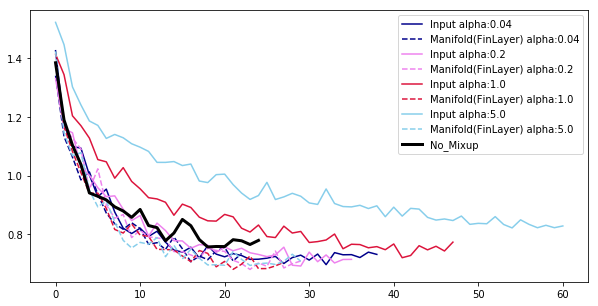

In [52]:
fig = plt.figure(figsize=(10,5,))
for mixup_alpha, color in zip([0.04, 0.2, 1.0, 5.0], ["darkblue", "violet", "crimson", "skyblue"]):
    
    loss_input_mixup = result_dict["standard_"+str(mixup_alpha)][0]
    loss_final_mixup = result_dict["fin_"+str(mixup_alpha)][0]    
    plt.plot(np.arange(len(loss_input_mixup)),loss_input_mixup,label="Input alpha:"+str(mixup_alpha),color=color,linestyle="solid")
    plt.plot(np.arange(len(loss_final_mixup)),loss_final_mixup,label="Manifold(FinLayer) alpha:"+str(mixup_alpha),color=color,linestyle="dashed")
loss = result_dict["No_Mixup"][0]
plt.plot(np.arange(len(loss)),loss,label=key,color="black",linestyle="solid",linewidth=3)
plt.legend()
    

In [54]:
for mixup_alpha in [0.04, 0.2, 1.0, 5.0]:
    print(result_dict["standard_"+str(mixup_alpha)][1][1][0])
            

0.6961753495559571
0.6914275110147561
0.7198351067342575
0.821438484131151


In [55]:
for mixup_alpha in [0.04, 0.2, 1.0, 5.0]:
    print(result_dict["fin_"+str(mixup_alpha)][1][1][0])

0.7060384139133866
0.6797995030120679
0.6800978624137344
0.6934822059361039


In [59]:
print(result_dict["No_Mixup"][1][1][0])

0.7564877387444684


|alpha| No Mixup |Input Mixup|Final Layer Mixup| 
|-|-|-|-|
|(No mixup) | 0.7576 | - | -|
|0.04|-|0.696|0.706|
|0.2|-|0.691|__0.680__|
|1.0|-|0.720|__0.680__|
|5.0|-|0.821|0.693|